# Heart Disease Classification
Phase 3 Project by Bella Scribner
- Flex
- Morgan Jones
- Date of Project Review:
- Blog: 

# Intro + Data Exploration
- The Business + Buisness Problem
- Overview of project goals/what want to accomplish in order to 'solve' or address the business problem

- Data Exploration
    - What data set working with
    - Explination of the columns (identify target)
    - .describe, .info, .value counts of target (introduce idea of maybe needing SMOTE)
    - Missing Data? --> how might handle based on what kind of data is missing (and how much)

1. Some nice intro about heart disease
    - paraphrase + cite Kaggle here
2. Business + Business Problem
    - Health care provider who would like model to predict wheather or not a patient has heart disease.  Can provide better care and hopefully catch more cases before someone becomes terminal
    - Recall is going to be important here -- missing someone with heart disease could be potentially fatal for the patient.  On the other hand, we do want to minimize false positives as well seeing as further screening and tests can have financial implications for the patients.  Thus we will want a nice balance between accuracy and recall for this model.

3. Let's dig into the data!

In [1]:
## REMEMBER:
# Accuracy: how often model is correct overall
# Recall: how well can model find all objects of the target class
# Precision: how often the model is correct when predicting the target class

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, \
cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import plot_confusion_matrix, recall_score, \
accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

In [3]:
data = pd.read_csv("heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
# Ideally wanted 1000 rows for this project -- want to save as much info as can...

| Column | Description | 
|:----|:----|
| **Age** | Age of the patient | 
| **Sex** | Sex of the patient |
| **ChestPainType** | Chest Pain Type: Typical Angina (TA), Atypical Angina (ATA), Non-Anginal Pain (NAP), or Asymptomatic (ASY) |
| **RestingBP** | Resting blood pressure (mm Hg) |
| **Cholesterol** | Serum Cholesterol (mm/dl) |
| **FastingBS** | Fasting blood sugar: 1 if FastingBS > 120 mg/dl, otherwise 0 |
| **REstingECG** | Resting electrocardiogram results: Normal (Normal), Having ST-T wave abnormality (ST), Showing probable or definite left ventricular hypertrophy by Estes' criteria (LVH) | 
| **MaxHR** | Maximum heart rate achieved |
| **ExerciseAngina** | Yes if exercise-induced angina is present, otherwise No |
| **Oldpeak** | ST depression ('ST' relates to positions on the ECG plot) | 
| **ST_Slope** | The slope of the peak exercise ST segment: Upsloping (Up), Flat (flat), or Downsloping (Down) | 
| **HeartDisease** | Target: 1 if the patient has heart disease, otherwise 0 |

In [6]:
# Missing Values?
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [7]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [8]:
# Most Fasting Blood Sugars are not above the cuttoff of 120 mg/dl
# Check out 0 entries for: RestingBP and Cholesterol (missing values?)

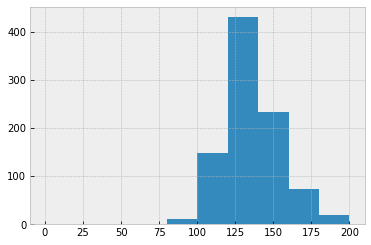

In [9]:
data['RestingBP'].hist();

In [10]:
data[data['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [11]:
# Only one entry of 0 Resting Blood Pressure - drop the entry.

In [12]:
data = data[data['RestingBP'] != 0]

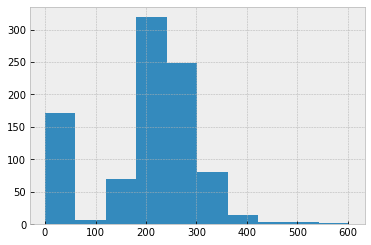

In [13]:
data['Cholesterol'].hist();

In [14]:
data[data['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [15]:
data[data['Cholesterol'] == 0]['HeartDisease'].value_counts()

1    151
0     20
Name: HeartDisease, dtype: int64

In [16]:
data['HeartDisease'].value_counts()

1    507
0    410
Name: HeartDisease, dtype: int64

In [17]:
data['HeartDisease'].value_counts(normalize=True)

1    0.55289
0    0.44711
Name: HeartDisease, dtype: float64

In [18]:
# So, we have 171 entries with a zero value for Cholesterol. Of these, a vast majority are entires where the patient does
    # have heart disease.  We do not want to lose this many data points and will need to be very careful on the method
    # of which these missing values are filled.
    
# For now, we will replace values of 0 to NaN so an imputer of some sort can be utlized in later processing.

In [19]:
data.replace({'Cholesterol': {0 :np.nan}}, inplace=True)

In [20]:
data.isna().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       171
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

In [21]:
# Take a peak at correlation

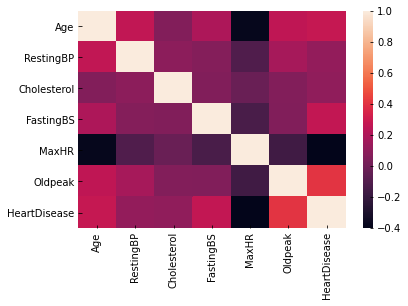

In [22]:
sns.heatmap(data.corr());

In [23]:
# Looks good!

# Data Pre-processing

- Train Test Split
- If missing values --> handle + explian why chosen method(s)
- Categorical columns -- > encode (don't forget handel unknown = ignore)
- SMOTE --> see lecture! imblear's pipelines!!

### NOTE ---> wondering if I should do this in a pipeline at first? Or for simple, initial model, do 'by hand' preprocessing and then convert into pipeline???

## Important to choose what types of models going to try!!
- some models require scaling of numberical values --> need to get into data and decide which models seem most appropriate and if some of those models require scaling --> add to preprocessing/pipeline

THis is where it will get a little tricky to stay organized. Different models need different preprocessing --> should just create pipeline for each model I suppose to keep it as clean as possible.  Plus can use pipeline + grid search (+cross validation) for later on...

In [24]:
# Split data - using default settings
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 7)

In [25]:
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
64,50,F,ATA,110,202.0,0,Normal,145,N,0.0,Up
736,54,M,ASY,122,286.0,0,LVH,116,Y,3.2,Flat
271,32,F,ATA,105,198.0,0,Normal,165,N,0.0,Up
633,64,M,TA,110,211.0,0,LVH,144,Y,1.8,Flat
879,48,M,ATA,110,229.0,0,Normal,168,N,1.0,Down


In [26]:
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
# We will include FastingBS as this is an over/under cutt off value 

In [27]:
# Encoding of Categorical Data
X_encoded = ColumnTransformer(transformers = [("ohe", OneHotEncoder(handle_unknown="ignore", sparse = False),
                                                  cat_cols)], remainder = 'passthrough')

# ???

- Scale before or after encoding? Also, should I seperate this out because not all of the models need to be scaled?
- Also, best way to get labels out now that pipeline is done for readability?

In [28]:
preprocess_pipe = Pipeline(steps = [
    ('encode', X_encoded),
    ('num_impute', SimpleImputer()),
    ('ss', StandardScaler())
])

In [29]:
#transformed_data = preprocess_pipe.fit_transform(X_train)

In [30]:
#transformed_data.shape

# Model Iteration (3 minimum)
- Go through the different models
    - why chose each model?
    - quick evaluation of each model
    - iterate through (hopefully improving) each model
- Evaluation:
    - appropriate metric for business problem!! indicate reasoning for which metric(s) using for each model DO NOT try to use all at once

In [31]:
# Logistic Regression
# KNN
# Classification Tree (?? Needed if doing Random Forest? ??)
# Random Forest
# XGBOOST

In [32]:
logistic_regression_pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipe),
    ('logistic_regression', LogisticRegression())
])

cv_score_LR = cross_val_score(logistic_regression_pipe, X_train, y_train)
cv_score_LR

array([0.86956522, 0.86231884, 0.86861314, 0.8540146 , 0.81021898])

In [33]:
cv_score_LR.mean()

0.8529461546598963

In [34]:
# Logistic Regression uses a default scoring of accuracy.  With cross validation we can see that we have a mean accuracy of
    # about 85%

## ??
Question -- want to do Recall Score here as well, but I don't want to use my X_test and y_test yet --> thinking I should only use those at the very end.  Should I create another 'hold out'/'validation' "test" set so I can pull this metric without leakage?  That seems like the proper answer...

In [ ]:
# NOTE TO SELF --> maybe set up a function so can see all the scores easier?

In [35]:
knn_pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipe),
    ('knn', KNeighborsClassifier())
])

In [41]:
cross_val_score(knn_pipe, X_train, y_train)

array([0.89130435, 0.85507246, 0.88321168, 0.86861314, 0.82481752])

In [42]:
cross_val_score(knn_pipe, X_train, y_train).mean()

0.8646038294721252

In [48]:
classification_tree_pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipe),
    ('classification_tree', DecisionTreeClassifier())
])

In [49]:
cross_val_score(classification_tree_pipe, X_train, y_train)

array([0.81884058, 0.76811594, 0.81751825, 0.73722628, 0.82481752])

In [50]:
cross_val_score(classification_tree_pipe, X_train, y_train).mean()

0.7874854543531155

In [51]:
random_forest_pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipe),
    ('random_forest', RandomForestClassifier())
])

In [53]:
cross_val_score(random_forest_pipe, X_train, y_train)

array([0.88405797, 0.86956522, 0.87591241, 0.89781022, 0.86131387])

In [54]:
cross_val_score(random_forest_pipe, X_train, y_train).mean()

0.8733523749074369

In [38]:
xgboost_pipe = Pipeline(steps=[
    ('preprocess', preprocess_pipe),
    ('xgb', XGBClassifier())
])

In [55]:
cross_val_score(xgboost_pipe, X_train, y_train)

array([0.87681159, 0.85507246, 0.91240876, 0.84671533, 0.8540146 ])

In [57]:
cross_val_score(xgboost_pipe, X_train, y_train).mean()

0.8690045488204803

In [ ]:
# NEXT STEP
# --> Grid Search for either Random Forest, XGBoost or both
# --> Don't think it is necessary to grid search for anything else...

# Chose Final Model
- choose final model
- explain why
- findings + recommendations
    - model features - which ones important to model?
    - how well can model predict target?
    - contexts/situations where the predictions made by model would and would not be useful for your stakeholder and business problem
    - what should stakeholders DO with this information??
    - suggestions for how the buisness might modify certain input variables to achieve certain target results
    - ETC...
    - Limitations/Uncertainty in project?

In [40]:
# Feature importance --> how do I pull this out of the model again?